## 数据加载

In [1]:
from utils import *

In [4]:


# 1. 加载数据
file_path = 'data/summerOly_athletes_total_with_types.csv'
data = pd.read_csv(file_path)

# 2. 数据预处理

# 获取独特的运动项目、年份和代表队
sports = sorted(data['Type'].unique())  # 运动项目 S
years = sorted(data['Year'].unique())   # 奥运会年份 T
nocs = sorted(data['NOC'].unique())     # 国家代表队 N

# 构建映射表
sport_to_idx = {sport: i for i, sport in enumerate(sports)}
year_to_idx = {year: i for i, year in enumerate(years)}
noc_to_idx = {noc: i for i, noc in enumerate(nocs)}
print(sport_to_idx)
print(noc_to_idx)

# 保存映射表
np.save('data/noc_to_idx.npy', noc_to_idx)

S, T, N = len(sports), len(years), len(nocs)

# 3. 奖牌分布数据
result_tensor = np.zeros((S, T, N), dtype=float)

# 过滤掉没有奖牌的数据
data = data[data['Medal'] != 'No medal']
# 去重
data = data.drop_duplicates(subset=['Event', 'Year', 'Medal', 'NOC', 'Sport'])
# 保存去重后的数据
data.to_csv('data/summerOly_athletes_no_dup.csv', index=False)
                                      
# 3. 构建张量
for _, row in data.iterrows():
    sport_idx = sport_to_idx[row['Type']]
    year_idx = year_to_idx[row['Year']]
    noc_idx = noc_to_idx[row['NOC']]
    result_tensor[sport_idx, year_idx, noc_idx] += 1.0
    # if row['Medal'] == 'Gold':
    #     result_tensor[sport_idx, year_idx, noc_idx] += 1.0  # 标记该国家在该年该运动有奖牌
 



# 4. 保存结果
output_path = 'data/olympic_medals_with_type.npy'
np.save(output_path, result_tensor)
print(f"结果张量已保存到 {output_path}")
print(f"张量形状: {result_tensor.shape}")  # 输出 S*T*N 的张量形状

{'Artistic Sports': 0, 'Athletics': 1, 'Combat Sports': 2, 'Cycling Sports': 3, 'Endurance Sports': 4, 'Equestrian': 5, 'Extreme Sports': 6, 'Gymnastics': 7, 'Other Traditional Sports': 8, 'Racket Sports': 9, 'Small Ball Sports': 10, 'Team Ball Sports': 11, 'Water Sports': 12, 'Weapon Sports': 13, 'Winter Sports': 14}
{'AFG': 0, 'AHO': 1, 'ALB': 2, 'ALG': 3, 'AND': 4, 'ANG': 5, 'ANT': 6, 'ANZ': 7, 'ARG': 8, 'ARM': 9, 'ARU': 10, 'ASA': 11, 'AUS': 12, 'AUT': 13, 'AZE': 14, 'BAH': 15, 'BAN': 16, 'BAR': 17, 'BDI': 18, 'BEL': 19, 'BEN': 20, 'BER': 21, 'BHU': 22, 'BIH': 23, 'BIZ': 24, 'BLR': 25, 'BOH': 26, 'BOL': 27, 'BOT': 28, 'BRA': 29, 'BRN': 30, 'BRU': 31, 'BUL': 32, 'BUR': 33, 'CAF': 34, 'CAM': 35, 'CAN': 36, 'CAY': 37, 'CGO': 38, 'CHA': 39, 'CHI': 40, 'CHN': 41, 'CIV': 42, 'CMR': 43, 'COD': 44, 'COK': 45, 'COL': 46, 'COM': 47, 'CPV': 48, 'CRC': 49, 'CRO': 50, 'CRT': 51, 'CUB': 52, 'CYP': 53, 'CZE': 54, 'DEN': 55, 'DJI': 56, 'DMA': 57, 'DOM': 58, 'ECU': 59, 'EGY': 60, 'EOR': 61, 'ERI': 

In [27]:
# 对第一维进行求和
result_tensor = result_tensor.sum(axis=0)
# 保存结果
np.save('data/medal_count.npy', result_tensor)

In [5]:
# 检查
total = result_tensor[:,year_to_idx[2024],noc_to_idx['CHN']].sum()
print(total)


91.0


## 平滑操作

In [6]:
sport_to_idx_inv = {v: k for k, v in sport_to_idx.items()}
for idx in range(S):
    # 加载某一项运动对应的数据作为时间序列数据用于训练
    medal_dist = torch.tensor(np.load('data/olympic_medals_with_type.npy')[idx], dtype=torch.float32).numpy()

    # 加载对应的运动员数量-国家分布作为平滑参数
    sport = sport_to_idx_inv[idx]
    file_path = f'data/athletes_count/{sport}.csv'
    athletes_count = pd.read_csv(file_path)
    # 列索引中年份并不是顺序的，需要重新排序
    years = sorted(athletes_count.columns)
    athletes_count = athletes_count[years]
    # 重新组织列表，使其行的顺序与noc_to_idx一致
    athletes_count.set_index(athletes_count.columns[-1], inplace=True)
    athletes_count = athletes_count.reindex(nocs)
    athletes_count.reset_index(inplace=True)
    # 将数据转换为 NumPy 数组
    athletes_per_noc = athletes_count.values
    # 每一行的最后一项是NOC并转置，使每一行表示每一年的运动员数量-国家分布
    athletes_per_noc = athletes_per_noc[:, 1:].T


    # 对每个年份的分布进行平滑处理
    for i in range(T):
        medal_dist[i] = smooth_distribution(medal_dist[i], athletes_per_noc[i], smooth_factor=1, reduce_factor=0.1)
    # 保存平滑后的数据
    np.save(f'data/medals_dist_smoothed/{idx}.npy', medal_dist)


## 训练模型 （针对每一类运动）

In [97]:
# for idx in range(S):  

#     # 加载平滑后的数据转换
#     x = torch.tensor(np.load(f'data/medals_dist_smoothed/{idx}.npy'), dtype=torch.float32)
#     # x = torch.tensor(np.load('data/olympic_medals.npy')[idx], dtype=torch.float32)

#     T, N = x.size()  # 时间序列长度和向量维度

#     # 实例化模型
#     model = WeightOptimizer(T)

#     # 定义优化器
#     optimizer = optim.Adam(model.parameters(), lr=0.001)

#     # 训练循环
#     num_epochs = 5000
#     for epoch in range(num_epochs):
#         optimizer.zero_grad()  # 清除梯度
#         loss = model(x)  # 计算损失
#         loss.backward()  # 反向传播
#         optimizer.step()  # 更新权重参数
#         if (epoch + 1) % 100 == 0:
#             print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}")

#     # 查看学习到的权重
#     weights = model.weights
#     weights = weights.detach().numpy()
#     # 保存学习到的权重
#     np.save(f'data/weights/{idx}.npy', weights)

#     print(f"Learned weights for {idx}-th sport:", weights)


Epoch 100/5000, Loss: 2.9214
Epoch 200/5000, Loss: 2.8414
Epoch 300/5000, Loss: 2.7649
Epoch 400/5000, Loss: 2.6882
Epoch 500/5000, Loss: 2.6203
Epoch 600/5000, Loss: 2.5687
Epoch 700/5000, Loss: 2.5242
Epoch 800/5000, Loss: 2.4843
Epoch 900/5000, Loss: 2.4384
Epoch 1000/5000, Loss: 2.3849
Epoch 1100/5000, Loss: 2.4040
Epoch 1200/5000, Loss: 2.3752
Epoch 1300/5000, Loss: 2.3590
Epoch 1400/5000, Loss: 2.3495
Epoch 1500/5000, Loss: 2.3427
Epoch 1600/5000, Loss: 2.3372
Epoch 1700/5000, Loss: 2.3321
Epoch 1800/5000, Loss: 2.3259
Epoch 1900/5000, Loss: 2.3150
Epoch 2000/5000, Loss: 2.2189
Epoch 2100/5000, Loss: 2.3706
Epoch 2200/5000, Loss: 2.3499
Epoch 2300/5000, Loss: 2.3400
Epoch 2400/5000, Loss: 2.3334
Epoch 2500/5000, Loss: 2.3277
Epoch 2600/5000, Loss: 2.3205
Epoch 2700/5000, Loss: 2.3056
Epoch 2800/5000, Loss: 2.4075
Epoch 2900/5000, Loss: 2.3964
Epoch 3000/5000, Loss: 2.3841
Epoch 3100/5000, Loss: 2.3741
Epoch 3200/5000, Loss: 2.3660
Epoch 3300/5000, Loss: 2.3596
Epoch 3400/5000, Lo

In [28]:
# 测试模型
pred_medals = np.zeros(N)
target = 31 


for idx in range(S):
    # 加载平滑后的数据转换
    x = torch.tensor(np.load(f'data/medals_dist_smoothed/{idx}.npy'), dtype=torch.float32)
    # 转换为NumPy数组
    x = x.detach().numpy()

    # 加载学习到的权重
    weights = np.load(f'data/weights/{idx}_No-0.npy')
    weights[-1] = weights[-2] 

    # 乘以距离权重
    dist = torch.tensor([i for i in range(target, 0, -1)], dtype=torch.float32)  # (k,)
    # 通过 inverse_sigmoid 将距离映射为一个单调递减的权重序列
    dist_weights = inverse_sigmoid(dist).detach().numpy()  # (k,)

    # 最终权重为原始权重和距离权重的乘积
    k_weights = dist_weights * weights[:target]  # (k,)
    k_weights = k_weights / np.sum(k_weights)
    # 计算预测值
    x_pred = np.sum(k_weights.reshape(-1,1) * x[:target], axis=0)

    # 将预测值累加到总预测奖牌数
    pred_medals += x_pred 


# 输出预测结果 
# 使用总奖牌数rescale
total_medals_list = np.load('data/total_medals_list.npy')
# pred_medals = pred_medals / sum(pred_medals) * total_medals_list[-1] 
# 保存预测结果
np.save('data/result/pred_medals_test.npy', pred_medals)

# 找到预测结果最大的二十个国家的索引
idx_to_noc = {v: k for k, v in noc_to_idx.items()}
max_indices = np.argsort(pred_medals)[-20:]  # 获取前20名索引
# 倒排
max_indices = max_indices[::-1]
print("Top 20 countries with predicted medals in 2024:", [idx_to_noc[idx] for idx in max_indices])
print("Predicted medal counts:", pred_medals[max_indices])


Top 20 countries with predicted medals in 2024: ['CHN', 'JPN', 'USA', 'KOR', 'GER', 'RUS', 'CZE', 'MAS', 'INA', 'DEN', 'ESP', 'GBR', 'FRA', 'TPE', 'SUI', 'IND', 'AUS', 'CRO', 'SWE', 'ARG']
Predicted medal counts: [11.18226528  3.13943243  2.3133018   2.1404922   1.80265021  1.56159508
  1.49037123  1.47693717  1.3610146   1.31055963  1.28358698  1.00487781
  0.93682241  0.84907544  0.70663393  0.64642042  0.54260319  0.49482358
  0.44808769  0.41262582]


## 可视化与评估

In [118]:
# import numpy as np
# from scipy.stats import pearsonr

# def calculate_metrics(true_values, predicted_values, k=7):
#     """
#     计算均绝对百分比误差 (MAPE)、皮尔逊相关系数 (PCC) 和 Top-k 准确率
    
#     参数:
#     - true_values: 真实值的 N 维向量 (numpy array)
#     - predicted_values: 预测值的 N 维向量 (numpy array)
#     - k: 用于 Top-k 准确率的阈值 (默认 10)
    
#     返回:
#     - MAPE: float
#     - PCC: float
#     - Top-k 准确率: float
#     """

#     # 计算皮尔逊相关系数 (PCC)
#     pcc, _ = pearsonr(true_values, predicted_values)

#     # 计算 Top-k 准确率
#     # 排序索引
#     true_top_k = set(np.argsort(true_values)[-k:])  # 真实值的 Top-k 索引
#     predicted_top_k = set(np.argsort(predicted_values)[-k:])  # 预测值的 Top-k 索引
#     top_k_accuracy = len(true_top_k.intersection(predicted_top_k)) / k  # 交集数目 / k

#     # 计算均绝对百分比误差 (MAPE)
#     # 注意：为了避免除以零错误，当 true_values 为零时，我们不计入误差, 因此首先将 true_values 中的零项剔除，并相应剔除 predicted_values 中的对应项
#     true_values_temp = true_values[true_values != 0]
#     predicted_values = predicted_values[true_values != 0]
#     mape = np.mean(np.abs((true_values_temp - predicted_values) / true_values_temp)) * 100

#     return mape, pcc, top_k_accuracy

# # 加载真实值和预测值
# true_values_all = np.load('data/medal_count.npy')
# true_values = true_values_all[year_to_idx[2024]]
# pred_values = np.load('data/result/pred_medals_test.npy') 
# # 计算指标
# mape, pcc, top_k_accuracy = calculate_metrics(true_values, pred_values, k=10)

# # 打印结果
# print(f"Mean Absolute Percentage Error (MAPE): {mape:.5f}%")
# print(f"Pearson Correlation Coefficient (PCC): {pcc:.5f}")
# print(f"Top-k Accuracy (k=10): {top_k_accuracy:.5f}")


Mean Absolute Percentage Error (MAPE): 37.39329%
Pearson Correlation Coefficient (PCC): 0.94778
Top-k Accuracy (k=10): 0.90000


77
[ 1.84782929e-01  7.08427370e-01  1.99344314e-01  1.95015902e-01
  2.39361139e-01  3.65448648e-01  1.71874419e-01  1.42423942e-01
  3.89919914e-01  9.31362119e-02  2.76211342e-01  7.76790847e-02
  1.50621619e-01  1.09598918e-01  2.74067049e-01  2.34850053e-01
  4.00424946e-02  1.55774207e-01  2.49080556e-01  9.43977719e-02
  3.29476065e-08  5.26240089e-01  1.34692296e-01  1.44263949e-01
  1.33745947e-01  7.72376059e-02  2.01624743e-01  3.51195430e-01
  4.87446328e-01  1.17710326e-01  1.77608568e-01  1.25708208e-01
  2.18155531e-01  9.19412365e-02  1.25679188e-01  1.90084586e-01
  1.68876628e-01  3.59447496e-01  3.82094462e-04  7.59514922e-02
  1.41058438e-01  1.33175323e-01  2.36865519e-01  2.82080584e-01
  5.19166827e-02  2.34151500e-01  3.58943440e-06  4.04609731e-01
  2.06865138e-01  1.55862670e-09  2.08697928e-01  1.78391306e-01
  1.54469210e-01  1.15005723e-01  4.54292120e-01  1.76021273e-04
  5.90536172e-02  2.08178494e-01  1.66005864e-04  5.46527526e-01
  3.43019603e-01  1.33

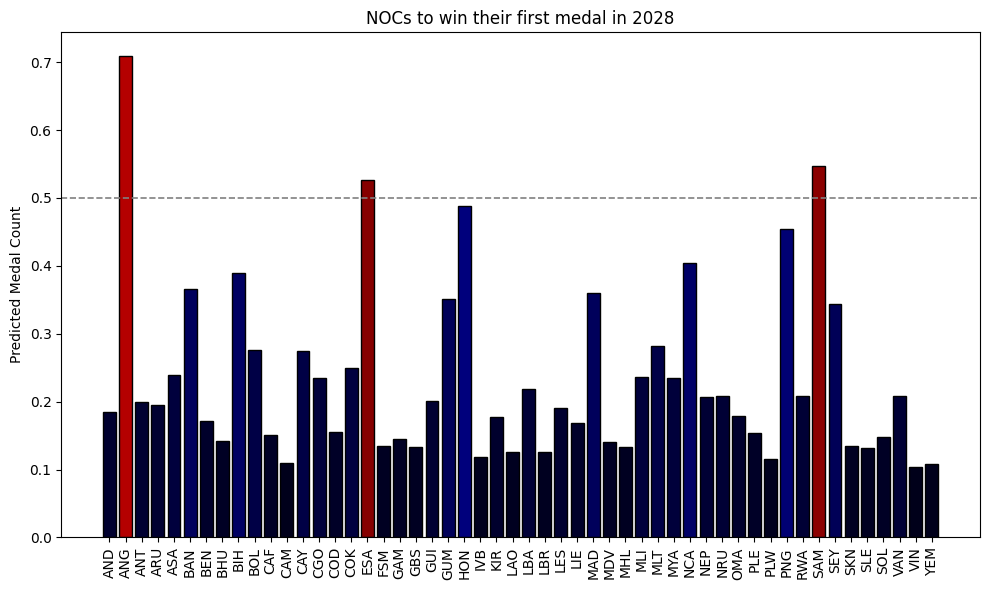

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# import matplotlib.colors as mcolors

# # 加载data/olympic_medals_with_type.npy
# data = np.load('data/olympic_medals_with_type.npy')
# # 计算每个国家获得的奖牌总数，即对前两维求和
# medal_counts = np.sum(data, axis=(0, 1))
# # 找到奖牌总数为0的国家
# nocs_never = np.where(medal_counts == 0)[0]
# print(len(nocs_never))


# # 获得nocs_never的预测值
# nocs_never_pred = pred_medals[nocs_never] 
# print(nocs_never_pred)
# # 找到预测值大于0.1的国家对应的索引
# nocs_never_pred_idx = np.where(nocs_never_pred > 0.1)[0]
# print(len(nocs_never_pred_idx))
# print(nocs_never[nocs_never_pred_idx])
# # 打印这些国家的名称
# print([idx_to_noc[idx] for idx in nocs_never[nocs_never_pred_idx]])


# colors = []
# for value in nocs_never_pred[nocs_never_pred_idx]:
#     if value > 0.5:
#         # Red gradient for values > 0.5
#         colors.append(mcolors.to_rgba(f'#{int(255 * value):02X}0000'))
#     else:
#         # Blue gradient for values <= 0.5
#         colors.append(mcolors.to_rgba(f'#0000{int(255 * value):02X}'))

# # Create the bar chart
# plt.figure(figsize=(10, 6))
# plt.bar(range(len(nocs_never_pred_idx)), nocs_never_pred[nocs_never_pred_idx], color=colors, edgecolor='black')

# # Add horizontal dashed line at 0.5
# plt.axhline(y=0.5, color='gray', linestyle='--', linewidth=1.2)

# # Customize the x-ticks
# plt.xticks(range(len(nocs_never_pred_idx)), [idx_to_noc[idx] for idx in nocs_never[nocs_never_pred_idx]], rotation=90)


# # Add labels and title
# # plt.xlabel('Country')
# plt.ylabel('Predicted Medal Count')
# plt.title('NOCs to win their first medal in 2028')

# # Show the plot
# plt.tight_layout()
# plt.show()













In [75]:
# # 测试模型
# target = 31 

# medal_count_pre = np.load('data/olympic_medals_with_type.npy')


# all_sports_predict = []
# for idx in range(S):
#     # 加载平滑后的数据转换
#     x = torch.tensor(np.load(f'data/medals_dist_smoothed/{idx}.npy'), dtype=torch.float32)
#     # 转换为NumPy数组
#     x = x.detach().numpy()

#     # 加载学习到的权重
#     weights = np.load(f'data/weights/{idx}_No-0.npy')
#     weights[-1] = weights[-2] 

#     # 乘以距离权重
#     dist = torch.tensor([i for i in range(target, 0, -1)], dtype=torch.float32)  # (k,)
#     # 通过 inverse_sigmoid 将距离映射为一个单调递减的权重序列
#     dist_weights = inverse_sigmoid(dist).detach().numpy()  # (k,)

#     # 最终权重为原始权重和距离权重的乘积
#     k_weights = dist_weights * weights[:target]  # (k,)
#     k_weights = k_weights / np.sum(k_weights)
#     # 计算预测值
#     x_pred = np.sum(k_weights.reshape(-1,1) * x[:target], axis=0)

#     # rescale
#     x_pred = x_pred  / np.sum(x_pred) * np.sum(medal_count_pre[idx,-1,:])

#     all_sports_predict.append(x_pred)

# all_sports_predict = np.array(all_sports_predict).T
# all_sports_last = medal_count_pre[:,-1,:].T
# noc = noc_to_idx['GBR']

# print(all_sports_predict[noc])
# print(all_sports_last[noc])


[-0.        29.2149    11.724127   4.460653   1.4387833  1.8447881
  5.482822   7.8619056  1.6105598  2.6758807  1.1125749  8.058653
 34.112846   8.382929   0.       ]
[ 0. 34. 10.  4.  2.  1.  6.  9.  2.  2.  1.  8. 32. 11.  0.]


/SSD_DISK/users/yaoyuxuan/anaconda3/envs/gaussian_splatting/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning:

FixedFormatter should only be used together with FixedLocator



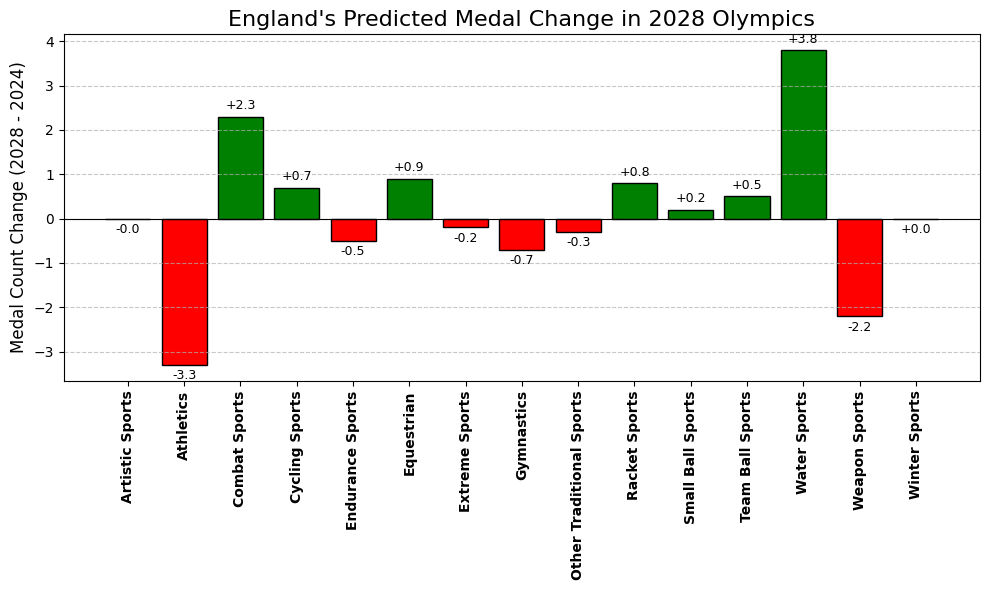

In [77]:
# import numpy as np
# import matplotlib.pyplot as plt


# idx_to_sport = {u:v for v, u in sport_to_idx.items()}

# projects = [f"{idx_to_sport[i]}" for i in range(15)]
# scores_before = all_sports_last[noc]
# scores_after = all_sports_predict[noc]


# changes = scores_after - scores_before
# # 保留两位小数
# changes = [round(change, 1) for change in changes]

# # 绘图
# fig, ax = plt.subplots(figsize=(10, 6))
# colors = ['green' if change > 0 else 'red' for change in changes]
# bars = ax.bar(projects, changes, color=colors, edgecolor="black")

# # 添加变化值
# for bar, change in zip(bars, changes):
#     ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + (0.1 if change > 0 else -0.1), 
#             f"{change:+}", ha="center", va="bottom" if change > 0 else "top", fontsize=9)

# # 美化图表
# ax.axhline(0, color="black", linewidth=0.8)  # 添加基准线
# ax.set_title("England's Predicted Medal Change in 2028 Olympics", fontsize=16)
# # ax.set_xlabel("Sports", fontsize=12)
# ax.set_ylabel("Medal Count Change (2028 - 2024)", fontsize=12)
# ax.set_xticklabels(projects, rotation=90, fontsize=10,fontweight='bold')
# ax.grid(axis="y", linestyle="--", alpha=0.7)

# plt.tight_layout()
# plt.show()